# Proyecto volatilidad dinámica

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import randn, seed
from scipy.optimize import minimize


**Modelo Heteroscedástico**
$$
    t_n|t_{n-1} \sim \mathcal{N}(\mu, \sigma^2(t_{n-1}))
$$


In [69]:
%config InlineBackend.figure_format = "retina"

In [70]:
market = pd.read_excel(r"C:\Users\AN012491\Desktop\Prueba.xlsx","Precios",index_col=0)
market.columns = [c.replace(" MF Equity", "").replace(" INDEX", "") for c in market.columns]

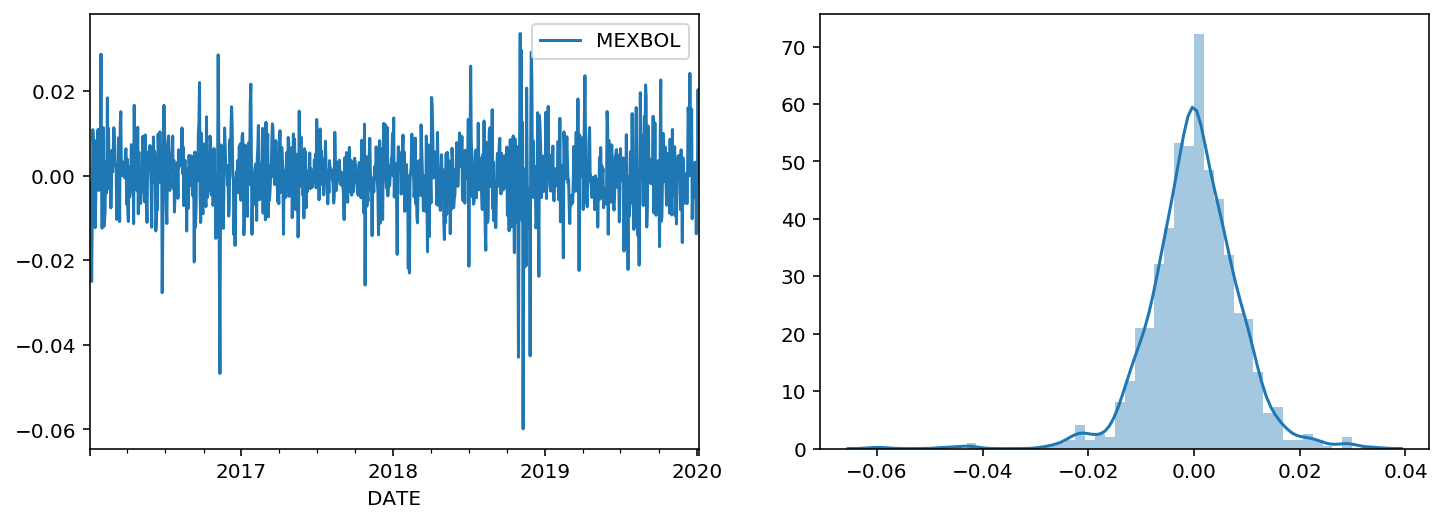

In [71]:
R = market[["MEXBOL"]]
R = np.log(R).diff().dropna()
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
R.plot(ax=ax[0])
sns.distplot(R, ax=ax[1])
plt.show()

In [72]:
test_year = "2019"
R_train = R[:test_year]
R_test = R[test_year:]

## GARCH

$$
    \sigma_t^2 = \omega + \alpha r^2_{t-1} + \beta\sigma^2_{t-1}
$$

$$
    \log L = \sum_{t=1}^T\left(\log \sigma_t^2 + \frac{r_t^2}{\sigma_t^2}\right)
$$

## Modelo de Volatilidad Dinámica

$$
    \sigma_t^2 = (1 - \lambda) r^2_{t-1} + \lambda \sigma_{t-1}^2
$$

In [73]:
class GARCHSigmas:
    """
    Clase para estimar sigmas para un GARCH(1, 1)
    """
    def __init__(self, omega, alpha, beta, sigma_init, R):
        self.omega = omega
        self.alpha = alpha
        self.beta = beta
        self.R = R
        self.sigma_hist = [sigma_init]
        self.initialize_sigmas()
        
    def get_sigma1(self, t):
        """
        Calcula sigma_t dado datos en t - 1
        """
        rt0 = 0 if t == 0 else self.R.iloc[t - 1, 0]
        sigma0 = self.sigma_hist[-1]
        sigma1 = self.omega + self.alpha * rt0 ** 2 + self.beta * sigma0
        self.sigma_hist.append(sigma1)
    
    def initialize_sigmas(self):
        N, M = self.R.shape
        for t in range(N - 1, -1, -1):
            self.get_sigma1(t)

In [74]:
class GARCHSuavizacionExp:
    """
    Clase para estimar sigmas para un GARCH(1, 1)
    """
    def __init__(self, l, sigma_init, R):
        self.omega = 0
        self.alpha = 1-l
        self.beta = l
        self.R = R
        self.sigma_hist = [sigma_init]
        self.initialize_sigmas()
        
    def get_sigma1(self, t):
        """
        Calcula sigma_t dado datos en t - 1
        """
        rt0 = 0 if t == 0 else self.R.iloc[t - 1, 0]
        sigma0 = self.sigma_hist[-1]
        sigma1 = self.omega + self.alpha * rt0 ** 2 + self.beta * sigma0
        self.sigma_hist.append(sigma1)
    
    def initialize_sigmas(self):
        N, M = self.R.shape
        for t in range(N - 1, -1, -1):
            self.get_sigma1(t)

In [75]:
def LGarch(omega, alpha, beta, sigma_init, R):
    s = GARCHSigmas(omega, alpha, beta, sigma_init, R)
    sigma_hist = np.array(s.sigma_hist[1:])
    r1_2 = R.values.ravel() ** 2
    log_likelihood = (np.log(sigma_hist) + r1_2 / sigma_hist).sum() / 2
    return log_likelihood
def LGarch_SE(l, sigma_init, R):
    s = GARCHSuavizacionExp(l, sigma_init, R)
    sigma_hist = np.array(s.sigma_hist[1:])
    r1_2 = R.values.ravel() ** 2
    log_likelihood = (np.log(sigma_hist) + r1_2 / sigma_hist).sum() / 2
    return log_likelihood

In [76]:
#Parámetros de los modelos:

seed(314)
omega, alpha, beta = np.abs(randn(3))
sigma_init = R.var(ddof=1).item() / 252
l=np.abs(np.random.rand(1))

# Configuración del modelo
x0 = np.array([omega, alpha, beta])
L_part = lambda x0: LGarch(*x0, sigma_init, R)

x0_SE = np.array([l])
L_part_SE = lambda x0: LGarch_SE(*x0_SE, sigma_init, R)

def cons(x):
    return x[1] + x[2] - 1

# restricción de no negativos
bounds = [
    (0, None),
    (0, None),
    (0, None)
]

bounds_SE = [
    (0, None),
]

C:\Users\AN012491\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: `item` has been deprecated and will be removed in a future version
  """


In [77]:
#Modelo GARCH(1,1) general
fmin = minimize(L_part, x0,
         constraints={"type": "ineq", "fun": cons},
         bounds=bounds)

C:\Users\AN012491\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
C:\Users\AN012491\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
C:\Users\AN012491\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
C:\Users\AN012491\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in add
  """


In [78]:
#Modelo GARCH(1,1) con suavización exponencial
fmin_SE = minimize(L_part_SE, x0_SE,
         bounds=bounds_SE)

In [79]:
#Parámetros óptimos del modelo GARCH(1,1) general
omega_garch, alpha_garch, beta_garch = fmin.x
#Parámetros óptimos del modelo GARCH con suavización exponencial
l_garch = fmin_SE.x[0]

In [80]:
# Volatilidades sigma2:

sigma0 = sigma_init
garch_predict = []
for i in range(len(R)):
    sigma0 = omega_garch + alpha_garch * R.iloc[i].item() ** 2 + beta_garch * sigma0
    garch_predict.append(sigma0)

sigma0 = sigma_init
garch_SE_predict = []
for i in range(len(R)):
    sigma0 = (1-l_garch) * R.iloc[i].item() ** 2 + l_garch * sigma0
    garch_SE_predict.append(sigma0)

C:\Users\AN012491\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: `item` has been deprecated and will be removed in a future version
  
C:\Users\AN012491\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: `item` has been deprecated and will be removed in a future version
  if sys.path[0] == '':


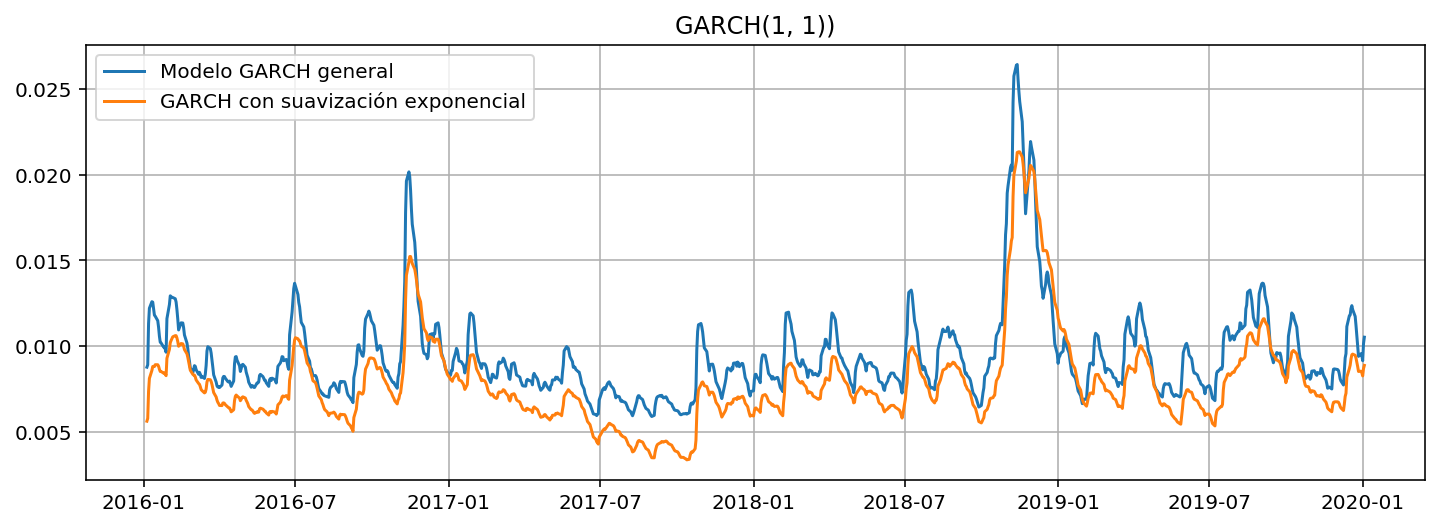

In [81]:
xaxis = R.index[1:]
sigma_garch = pd.Series(np.sqrt(garch_predict)[1:])
sigma_garch_SE = pd.Series(np.sqrt(garch_SE_predict)[1:])

plt.subplots(figsize=(12, 4))
plt.title("GARCH(1, 1))")
plt.grid()
plt.plot(xaxis, sigma_garch.ewm(2).mean(),label="Modelo GARCH general");
plt.plot(xaxis, sigma_garch_SE.ewm(2).mean(),label="GARCH con suavización exponencial");
plt.legend()
plt.show()